In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Apr 25 00:31:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Descomprimir el ZIP en Colab con un solo comando estilo shell
!unzip -q "/content/drive/MyDrive/real_vs_fake.zip" -d /content/real_vs_fake

unzip:  cannot find or open /content/drive/MyDrive/real_vs_fake.zip, /content/drive/MyDrive/real_vs_fake.zip.zip or /content/drive/MyDrive/real_vs_fake.zip.ZIP.


In [ ]:
!ls /content/real_vs_fake/real_vs_fake


test  train  valid


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers      import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models      import Model
from tensorflow.keras.optimizers  import Adam

In [ ]:
BASE_DIR = '/content/real_vs_fake/real_vs_fake'
print(f"Usando BASE_DIR: {BASE_DIR}")

INPUT_SHAPE = (299, 299, 3)
BATCH_SIZE   = 32



Usando BASE_DIR: /content/real_vs_fake/real_vs_fake


In [ ]:
# 1) Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_gen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_DIR, 'train')
valid_dir = os.path.join(BASE_DIR, 'valid')
test_dir  = os.path.join(BASE_DIR, 'test')

print('Train directory:', train_dir)
print('Valid directory:', valid_dir)
print('Test  directory:', test_dir)


Train directory: /content/real_vs_fake/real_vs_fake/train
Valid directory: /content/real_vs_fake/real_vs_fake/valid
Test  directory: /content/real_vs_fake/real_vs_fake/test


In [ ]:
train_gen = data_gen.flow_from_directory(train_dir, target_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE, class_mode='binary')

valid_gen = data_gen.flow_from_directory( valid_dir, target_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE, class_mode='binary')

test_gen = data_gen.flow_from_directory( test_dir, target_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
def create_model(dropout_rate, dense_units, learning_rate):

# First we built the Xception model base with imaginet

    base = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base.trainable = False

# then we added the classification head
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=preds)
    model.compile(optimizer=Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy']
    )

    return model

In [ ]:
# 3) we crated a for loop for the grid search (reduced)

best_acc = 0
best_params = None
best_model = None

for dr in [0.2, 0.4]:
    for du in [128, 256]:
        for lr in [1e-4, 1e-5]:
            print(f'Trying dropout={dr}, dense_units={du}, lr={lr}')
            model = create_model(dr, du, lr)
            history = model.fit(
                train_gen,
                epochs=3,
                validation_data=valid_gen,
                verbose=1
            )
            val_acc = history.history['val_accuracy'][-1]
            if val_acc > best_acc:
                best_acc = val_acc
                best_params = (dr, du, lr)
                best_model = model

print('→ Best params:', best_params, '→ best val_accuracy:', best_acc)

Trying dropout=0.2, dense_units=128, lr=0.0001
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 326s 100ms/step - accuracy: 0.7366 - loss: 0.5209 - val_accuracy: 0.8165 - val_loss: 0.4084
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 307s 98ms/step - accuracy: 0.8200 - loss: 0.3989 - val_accuracy: 0.8393 - val_loss: 0.3690
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - accuracy: 0.8381 - loss: 0.3676 - val_accuracy: 0.8461 - val_loss: 0.3503
Trying dropout=0.2, dense_units=128, lr=1e-05
Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 322s 101ms/step - accuracy: 0.6622 - loss: 0.6124 - val_accuracy: 0.7508 - val_loss: 0.5169
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accuracy: 0.7544 - loss: 0.5113 - val_accuracy: 0.7766 - val_loss: 0.4797
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 310s 99ms/step - accuracy: 0.7719 - loss: 0.4829 - val_accuracy: 0.7870 - val_loss: 0.4581
Trying dropout=0.2, dense_units=256, lr=0.0001
Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 319s 99ms/step - accuracy: 0.7537 - loss: 0.4988 - val_accuracy: 0.8266

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_xception.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

history = best_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=callbacks, verbose=1)


Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8658 - loss: 0.3160
Epoch 1: val_loss improved from inf to 0.31180, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 307s 98ms/step - accuracy: 0.8658 - loss: 0.3160 - val_accuracy: 0.8659 - val_loss: 0.3118
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8736 - loss: 0.2993
Epoch 2: val_loss improved from 0.31180 to 0.30001, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 311s 99ms/step - accuracy: 0.8736 - loss: 0.2993 - val_accuracy: 0.8714 - val_loss: 0.3000
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8814 - loss: 0.2823
Epoch 3: val_loss improved from 0.30001 to 0.28828, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 308s 98ms/step - accuracy: 0.8814 - loss: 0.2823 - val_accuracy: 0.8755 - val_loss: 0.2883
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8914 - loss: 0.2646
Epoch 4: val_loss improved from 0.28828 to 0.28307, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accuracy: 0.8914 - loss: 0.2646 - val_accuracy: 0.8795 - val_loss: 0.2831
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8976 - loss: 0.2499
Epoch 5: val_loss improved from 0.28307 to 0.27130, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 305s 98ms/step - accuracy: 0.8976 - loss: 0.2499 - val_accuracy: 0.8833 - val_loss: 0.2713
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9040 - loss: 0.2380
Epoch 6: val_loss improved from 0.27130 to 0.26307, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 311s 99ms/step - accuracy: 0.9040 - loss: 0.2380 - val_accuracy: 0.8889 - val_loss: 0.2631
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9076 - loss: 0.2270
Epoch 7: val_loss improved from 0.26307 to 0.25862, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 308s 98ms/step - accuracy: 0.9076 - loss: 0.2270 - val_accuracy: 0.8909 - val_loss: 0.2586
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9118 - loss: 0.2201
Epoch 8: val_loss improved from 0.25862 to 0.25456, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 311s 99ms/step - accuracy: 0.9118 - loss: 0.2201 - val_accuracy: 0.8920 - val_loss: 0.2546
Epoch 9/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9176 - loss: 0.2077
Epoch 9: val_loss improved from 0.25456 to 0.24419, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - accuracy: 0.9176 - loss: 0.2077 - val_accuracy: 0.8970 - val_loss: 0.2442
Epoch 10/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9216 - loss: 0.1966
Epoch 10: val_loss improved from 0.24419 to 0.24081, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 307s 98ms/step - accuracy: 0.9216 - loss: 0.1966 - val_accuracy: 0.9000 - val_loss: 0.2408
Epoch 11/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9244 - loss: 0.1906
Epoch 11: val_loss did not improve from 0.24081
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 307s 98ms/step - accuracy: 0.9244 - loss: 0.1906 - val_accuracy: 0.8975 - val_loss: 0.2444
Epoch 12/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9296 - loss: 0.1792
Epoch 12: val_loss improved from 0.24081 to 0.23857, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 310s 99ms/step - accuracy: 0.9296 - loss: 0.1792 - val_accuracy: 0.8992 - val_loss: 0.2386
Epoch 13/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9338 - loss: 0.1728
Epoch 13: val_loss improved from 0.23857 to 0.22967, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 307s 98ms/step - accuracy: 0.9338 - loss: 0.1728 - val_accuracy: 0.9043 - val_loss: 0.2297
Epoch 14/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9359 - loss: 0.1647
Epoch 14: val_loss improved from 0.22967 to 0.22809, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 308s 99ms/step - accuracy: 0.9359 - loss: 0.1647 - val_accuracy: 0.9054 - val_loss: 0.2281
Epoch 15/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9381 - loss: 0.1580
Epoch 15: val_loss did not improve from 0.22809
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 306s 98ms/step - accuracy: 0.9381 - loss: 0.1580 - val_accuracy: 0.9034 - val_loss: 0.2355
Epoch 16/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9428 - loss: 0.1499
Epoch 16: val_loss improved from 0.22809 to 0.22163, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - accuracy: 0.9428 - loss: 0.1499 - val_accuracy: 0.9089 - val_loss: 0.2216
Epoch 17/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9443 - loss: 0.1448
Epoch 17: val_loss did not improve from 0.22163
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - accuracy: 0.9443 - loss: 0.1448 - val_accuracy: 0.9107 - val_loss: 0.2225
Epoch 18/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9478 - loss: 0.1375
Epoch 18: val_loss did not improve from 0.22163
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accuracy: 0.9478 - loss: 0.1375 - val_accuracy: 0.9046 - val_loss: 0.2346
Epoch 19/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9515 - loss: 0.1320
Epoch 19: val_loss improved from 0.22163 to 0.22121, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accuracy: 0.9515 - loss: 0.1320 - val_accuracy: 0.9096 - val_loss: 0.2212
Epoch 20/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9546 - loss: 0.1270
Epoch 20: val_loss improved from 0.22121 to 0.21462, saving model to best_xception.h5


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accuracy: 0.9546 - loss: 0.1270 - val_accuracy: 0.9140 - val_loss: 0.2146


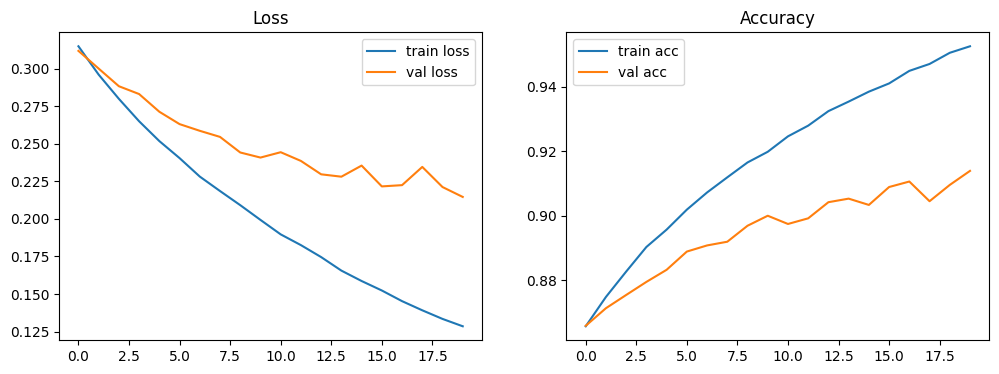

In [ ]:
# 5) After running the 20 epochs of the best model, we plot its loss & accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()


In [ ]:
# 6) Final evaluation & metrics on validation and test
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             roc_curve, auc)

# validation
print("\n--- VALIDATION EVALUATION ---")
val_loss, val_acc = best_model.evaluate(valid_gen, verbose=1)
print(f"Val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

# test
print("\n--- TEST EVALUATION ---")
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")


--- VALIDATION EVALUATION ---
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9108 - loss: 0.2214
Val loss: 0.2146, val acc: 0.9140

--- TEST EVALUATION ---
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.9217 - loss: 0.1991
Test loss: 0.2159, test acc: 0.9136


In [ ]:
# preds on test
y_true = test_gen.classes
y_prob = best_model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# confusion matrix + classification report
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report (test):")
print(classification_report(y_true, y_pred, digits=4))

625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 82ms/step

Confusion Matrix (test):
[[9249  751]
 [ 978 9022]]

Classification Report (test):
              precision    recall  f1-score   support

           0     0.9044    0.9249    0.9145     10000
           1     0.9232    0.9022    0.9126     10000

    accuracy                         0.9135     20000
   macro avg     0.9138    0.9136    0.9135     20000
weighted avg     0.9138    0.9135    0.9135     20000



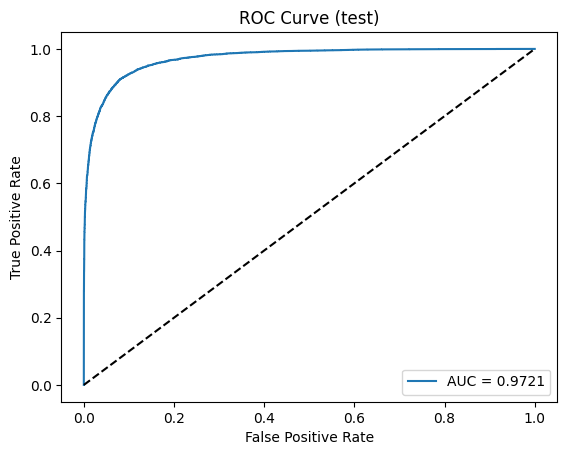

In [ ]:
# ROC curve + AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# 9) now we extract & save the features on train/valid/test
from tensorflow.keras.models import Model as KModel
import numpy as np

feat_extractor = KModel(
    inputs=best_model.input,
    outputs=best_model.layers[-3].output
)

out_dir = '/content/drive/MyDrive/tu_proyecto/xception_features'
os.makedirs(out_dir, exist_ok=True)

for split, gen in zip(['train','valid','test'], [train_gen, valid_gen, test_gen]):
    feats = feat_extractor.predict(gen, verbose=1)
    labels = gen.classes
    np.save(os.path.join(out_dir, f'features_{split}.npy'), feats)
    np.save(os.path.join(out_dir, f'labels_{split}.npy'), labels)

print("\n✅ All features saved.")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 83ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step

✅ All features saved.
